In [1856]:
!pip install torch pandas matplotlib seaborn scikit-learn

In [1857]:
#install packages and load them
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt



In [1858]:
# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

print(f"PyTorch version: {torch.__version__}")
print(f"GPU available: {torch.cuda.is_available()}")

PyTorch version: 2.9.0+cu126
GPU available: True


In [1859]:
df = pd.read_csv('heisman_finalists_complete_2000_2025_all.csv')

In [1860]:
print(df.head())


   year  place               player position         school   class  \
0  2000      1         Chris Weinke       QB  Florida State  Senior   
1  2000      2          Josh Heupel       QB       Oklahoma  Senior   
2  2000      3           Drew Brees       QB         Purdue  Senior   
3  2000      4  LaDainian Tomlinson       RB            TCU  Junior   
4  2001      1          Eric Crouch       QB       Nebraska  Senior   

   won_heisman  passing_yards  passing_tds  ints  ...  td_int_ratio  \
0            1           4167           33    11  ...      2.750000   
1            0           3606           20     5  ...      3.333333   
2            0           3668           25    12  ...      1.923077   
3            0              0            0     0  ...      0.000000   
4            1           1510            7    10  ...      0.636364   

   efficiency_score  elite_team  playoff_era first_place_votes  \
0       2163.846154           1            0               NaN   
1       1998.3

In [1861]:
df_winners = df[df['won_heisman'] == 1].copy() #adding feature columns for winners/runner ups (binary classification)

In [1862]:
#categorical variables encoding
le_position = LabelEncoder()
le_conference = LabelEncoder()
le_class = LabelEncoder()

In [1863]:
# Fit them on the data
df_winners['position_encoded'] = le_position.fit_transform(df_winners['position'].fillna('N/A'))
df_winners['conference_encoded'] = le_conference.fit_transform(df_winners['conference'].fillna('independent'))
df_winners['class_encoded'] = le_class.fit_transform(df_winners['class'].fillna('Senior'))


print(f'Position Encoding Mapping: {list(le_position.classes_)}')
print(f'Conference Encoding Mapping: {list(le_conference.classes_)}')
print(f'Class Encoding Mapping: {list(le_class.classes_)}')


Position Encoding Mapping: ['QB', 'RB', 'WR', 'WR/CB']
Conference Encoding Mapping: ['ACC', 'Big 12', 'Big Ten', 'Pac-10', 'Pac-12', 'SEC']
Class Encoding Mapping: ['Freshman', 'Junior', 'Senior', 'Sophomore']


In [1864]:
# INPUT FEATURES (what we know)
input_features = [
    'position_encoded',
    'conference_encoded',
    'class_encoded',
    'team_wins',
    'team_losses',
    'year',
    'win_percentage',
    'efficiency_score', #efficiency_score = (total_offense / games_total) + (total_tds * 50) made by claude 4.5 sonnet
    'td_int_ratio'
]


In [1865]:
# OUTPUT TARGETS (what we want to predict)
output_targets = [
    'total_offense',
    'total_tds',
    'passing_tds',
    'rushing_tds',
    'yards_per_game',
    'receiving_tds',
    'receptions'
]

In [1866]:
# Prepare arrays
X = df_winners[input_features].fillna(0).values
y = df_winners[output_targets].fillna(0).values

In [1867]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [1868]:
# Normalize (important for neural networks!)
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)
y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)

# Convert to PyTorch tensors
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

torch.Size([20, 9])
torch.Size([6, 9])
torch.Size([20, 7])
torch.Size([6, 7])


In [1869]:
class HeismanDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

train_dataset = HeismanDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=55, shuffle=True)

In [1870]:

class HeismanPredictor(nn.Module):
  #3 layer NN model with a dropout rate until last layer

    def __init__(self):
        super(HeismanPredictor, self).__init__()

        self.layer1 = nn.Linear(9, 16) #inputs
        self.layer2 = nn.Linear(16, 16) #NN layer (16 neuron Lienar NN)
        self.layer3 = nn.Linear(16, 7) #outputs

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.dropout(x)

        x = self.relu(self.layer2(x))
        x = self.dropout(x)

        x = self.layer3(x)  #no dropout needed for lin reg (end of model)
        return x

In [1871]:
  def forward(self, x):
        # Forward pass through layers
        x = self.relu(self.layer1(x))
        x = self.dropout(x)

        x = self.relu(self.layer2(x))
        x = self.dropout(x)

        x = self.layer3(x)  # No activation on output for regression
        return x

In [1872]:
# Create model
model = HeismanPredictor()

In [1873]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',           # Monitor a metric to be minimized (like loss)
    factor=0.1,           # Reduce learning rate by a factor of 10 (New LR = LR * 0.1)
    patience=15,          # Wait for 15 epochs with no improvement before reducing LR
    threshold=0.0001,     # Only consider an improvement if the change is > threshold
    threshold_mode='rel', # Use a relative threshold for improvement check
    cooldown=5,           # Wait for 5 epochs after a reduction before resuming normal operation
    min_lr=1e-6,          # Set the minimum learning rate to 1e-6
)

print(f"Initial Learning Rate: {optimizer.param_groups[0]['lr']}")

Initial Learning Rate: 0.001


In [1874]:
early_stopping = EarlyStopping(patience=20, delta=0)

num_epochs = 7500
losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    for batch_X, batch_y in train_loader:
        predictions = model(batch_X)
        loss = criterion(predictions, batch_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    losses.append(loss.item())
    model.eval()
    with torch.no_grad():
        val_predictions = model(X_test)
        val_loss = criterion(val_predictions, y_test)
    val_losses.append(val_loss.item())
    scheduler.step(val_loss.item())
    early_stopping(val_loss.item(), model)

    if early_stopping.early_stop:
        print(f"Early stopping at epoch {epoch+1}")
        break

    if (epoch + 1) % 50 == 0:
        current_lr = optimizer.param_groups[0]['lr']
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}, Current LR: {current_lr:.6f}')

early_stopping.load_best_model(model)
print("Training complete. Best model loaded.")

Epoch 50/7500, Training Loss: 0.9423, Validation Loss: 1.5735, Current LR: 0.001000
Epoch 100/7500, Training Loss: 0.9340, Validation Loss: 1.4399, Current LR: 0.001000
Epoch 150/7500, Training Loss: 0.8452, Validation Loss: 1.2430, Current LR: 0.001000
Epoch 200/7500, Training Loss: 0.7834, Validation Loss: 1.0615, Current LR: 0.001000
Epoch 250/7500, Training Loss: 0.4750, Validation Loss: 0.9407, Current LR: 0.001000
Epoch 300/7500, Training Loss: 0.8573, Validation Loss: 0.8479, Current LR: 0.001000
Epoch 350/7500, Training Loss: 0.7284, Validation Loss: 0.7523, Current LR: 0.001000
Early stopping at epoch 376
Training complete. Best model loaded.


In [1875]:
model.eval()

new_player = np.array([[
    np.random.uniform(0,8),     #random position (all offensive stats based on majority winners)
    np.random.uniform(0,6),  #conference (random, though big 10 is the majority)
    np.random.uniform(0,5),      # class_encoded
    np.random.randint(1, 13),     # team_wins (random between 1 and 12, inclusive)
    np.random.randint(0, 8),      # team_losses
    2026,                         # year
    np.random.uniform(0.5, 1.0),  # win_percentage (random float between 0.5 and 1.0)
    np.random.uniform(1000, 3000),# efficiency_score (random float)
    np.random.uniform(0.5, 5.0)   # td_int_ratio (random float)
]])

'''
    You ALWAYS have to remember that lists start at zero.
    Based on the encodings we've checked above these randomizations should be accurate.
    Also note inclusive random integers.
    input_features = [
    'position_encoded',
    'conference_encoded',
    'class_encoded',
    'team_wins',
    'team_losses',
    'year',
    'win_percentage',
    'efficiency_score', #efficiency_score = (total_offense / games_total) + (total_tds * 50) made by claude 4.5 sonnet
    'td_int_ratio'
]

   '''

"\n    You ALWAYS have to remember that lists start at zero.\n    Based on the encodings we've checked above these randomizations should be accurate.\n    Also note inclusive random integers.\n    input_features = [\n    'position_encoded',\n    'conference_encoded',\n    'class_encoded',\n    'team_wins',\n    'team_losses',\n    'year',\n    'win_percentage',\n    'efficiency_score', #efficiency_score = (total_offense / games_total) + (total_tds * 50) made by claude 4.5 sonnet\n    'td_int_ratio'\n]\n\n   "

In [1876]:
# Scale input
new_player_scaled = scaler_X.transform(new_player)
new_player_tensor = torch.FloatTensor(new_player_scaled)

# Predict
with torch.no_grad():
    prediction_scaled = model(new_player_tensor)
    # Inverse transform to get actual values
    prediction = scaler_y.inverse_transform(prediction_scaled.numpy())

# Get the actual position name using inverse_transform
predicted_position_encoded = int(new_player[0, input_features.index('position_encoded')])
predicted_position_name = le_position.inverse_transform([predicted_position_encoded])[0]


# Get the actual conference
predicted_conf_encoded = int(new_player[0, input_features.index('conference_encoded')])
predicted_conf_name = le_conference.inverse_transform([predicted_conf_encoded])[0]

# Display results
print("\nPredicted Stats for the next heisman winner (offensive player)")
print(f"Predicted Position: {predicted_position_name}")
print(f"Predicted Conference: {predicted_conf_name}")
print(f"  Total Offense: {prediction[0, 0]:.0f} yards")
print(f"  Total TDs: {prediction[0, 1]:.0f}")
print(f"  Yards per Game: {prediction[0, 4]:.0f}")


Predicted Stats for the next heisman winner (offensive player)
Predicted Position: WR
Predicted Conference: SEC
  Total Offense: 3842 yards
  Total TDs: 40
  Yards per Game: 293


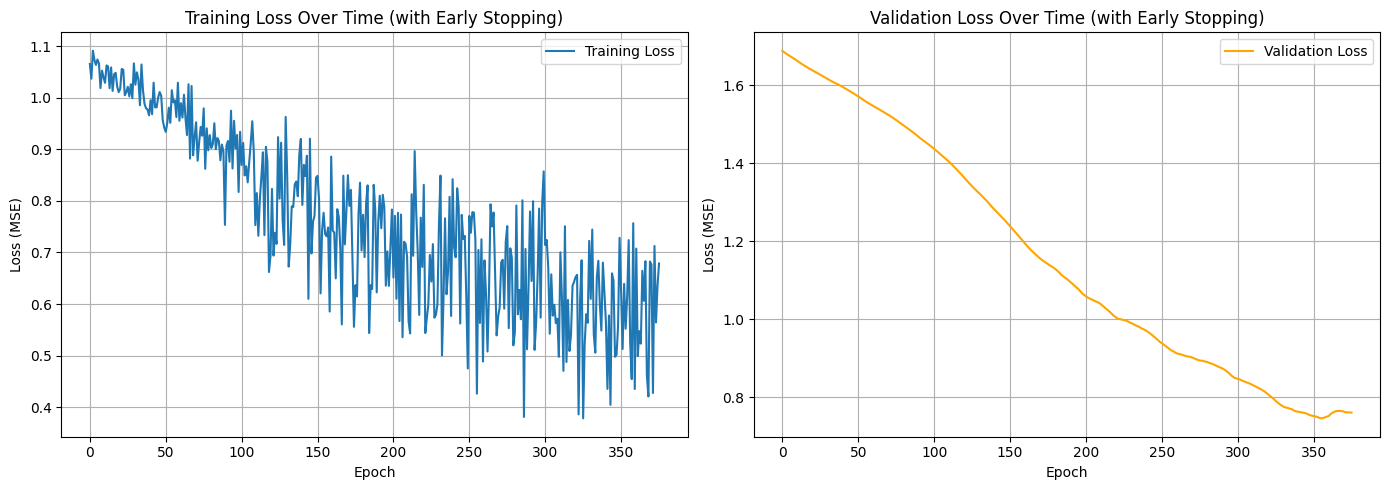

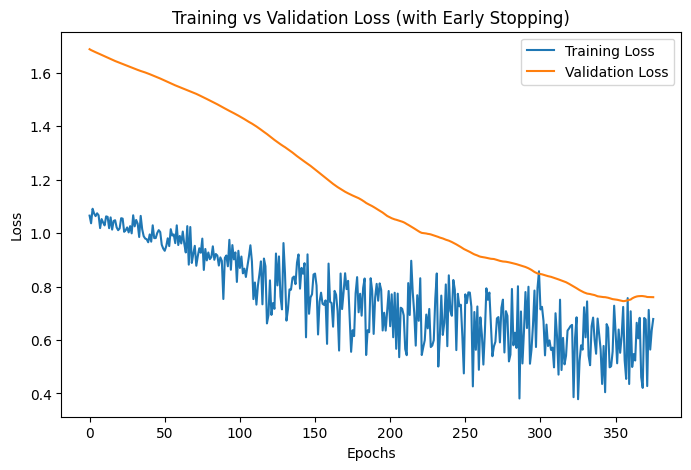

In [1877]:
# Create figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Training loss over time
ax1.plot(losses, label='Training Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (MSE)')
ax1.set_title('Training Loss Over Time (with Early Stopping)')
ax1.legend()
ax1.grid(True)

# Plot 2: Validation loss over time
ax2.plot(val_losses, label='Validation Loss', color='orange')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss (MSE)')
ax2.set_title('Validation Loss Over Time (with Early Stopping)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


# Plot 3: Validation loss Vs Training loss
plt.figure(figsize=(8,5))
plt.plot(losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training vs Validation Loss (with Early Stopping)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()